<a href="https://www.kaggle.com/code/sentienttrapezoid/fast-approach-to-spaceship-titanic?scriptVersionId=199792706" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


<h2>Data</h2>

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [3]:
train_dataset = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_dataset = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
train_dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Feature description, as defined in the dataset page:
<ul>
    <li><b>PassengerId</b> - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always. </li>
 <li> <b>  HomePlanet </b>- The planet the passenger departed from, typically their planet of permanent residence.</li>
<li> <b>   CryoSleep</b>- Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
<li> <b>Cabin</b>- The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.</li>
<li>  <b>  Destination </b>- The planet the passenger will be debarking to.
    Age - The age of the passenger.</li>
 <li>  <b> VIP </b>- Whether the passenger has paid for special VIP service during the voyage.</li>
  <li> <b> RoomService, FoodCourt, ShoppingMall, Spa, VRDeck </b>- Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.</li>
  <li><b>  Name</b> - The first and last names of the passenger.
    Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</li>
</ul>

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


All the columns except the target (Transported) and PassengerId have missing values, however the percentage is minimal:

In [5]:
def nan_finder(data):
    nan_prcntg = (data.isnull().sum() / len(data)).round(2)
    nan_prcntg.name = 'null values(%)'
    return nan_prcntg
nan_df = nan_finder(train_dataset)
nan_df

PassengerId     0.00
HomePlanet      0.02
CryoSleep       0.02
Cabin           0.02
Destination     0.02
Age             0.02
VIP             0.02
RoomService     0.02
FoodCourt       0.02
ShoppingMall    0.02
Spa             0.02
VRDeck          0.02
Name            0.02
Transported     0.00
Name: null values(%), dtype: float64

<h2>EDA</h2>

We produce specialized columns in the training dataset for the Passenger Group, Size and the cabin information divided in Deck, Number and Side:

In [6]:
X = train_dataset.copy()
X_test = test_dataset.copy()
X['Transported'] = X['Transported'].astype('Int64')
y = X['Transported']
X[['PassengerGroup', 'PassengerSize']] = X['PassengerId'].str.split('_', expand=True).astype('Int64')
X.drop(['PassengerId', 'Name'], axis=1, inplace=True)
X['CryoSleep'] = X['CryoSleep'].astype('Int64')
X['VIP'] = X['VIP'].astype('Int64')
X[['Deck', 'CabinNum', 'Side']] = X['Cabin'].str.split('/', expand=True)
X['CabinNum'] = X['CabinNum'].astype('Int64')
X.drop(['Cabin'], axis=1, inplace=True)


and likewise in the testing dataset:

In [7]:
X_test['CryoSleep'] = test_dataset['CryoSleep'].astype('Int64')
X_test[['PassengerGroup', 'PassengerSize']] = X_test['PassengerId'].str.split('_', expand=True).astype('Int64')
X_test['VIP'] = test_dataset['VIP'].astype('Int64')
X_test[['Deck', 'CabinNum', 'Side']] = test_dataset['Cabin'].str.split('/', expand=True)
X_test['CabinNum'] = X_test['CabinNum'].astype('Int64')
X_test.drop(['Cabin'], axis=1, inplace=True)

As a preliminary check we study the mutual information relations between the different features:

In [8]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

X_temp = X.copy().drop(['Transported'], axis=1)
for colname in X_temp.select_dtypes("object"):
    X_temp[colname], _ = X_temp[colname].factorize()
    
discrete_features = ((X_temp.dtypes == 'Int64').values | (X_temp.dtypes == int).values)

def mi_score_f(X, y, discrete_features='auto'):
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features)
    mi_df = pd.Series(mi_scores, name = 'MI Scores', index = X.columns)
    mi_df = mi_df.sort_values(ascending=False)
    return mi_df

X_temp = X_temp.fillna(X.mode().iloc[0])
mi_scores = mi_score_f(X_temp, y, discrete_features=discrete_features)
mi_scores

PassengerGroup    0.512914
CabinNum          0.143284
CryoSleep         0.112254
Spa               0.072442
RoomService       0.069684
VRDeck            0.062391
ShoppingMall      0.048893
FoodCourt         0.047470
Deck              0.023157
HomePlanet        0.018931
Destination       0.006161
Side              0.005271
Age               0.005233
PassengerSize     0.004350
VIP               0.000700
Name: MI Scores, dtype: float64

PassengerGroup, CabinNum and CryoSleep seems to have a relation with the target.

We divide the dataset features according to their cardinality:

In [9]:
X.nunique()

HomePlanet           3
CryoSleep            2
Destination          3
Age                 80
VIP                  2
RoomService       1273
FoodCourt         1507
ShoppingMall      1115
Spa               1327
VRDeck            1306
Transported          2
PassengerGroup    6217
PassengerSize        8
Deck                 8
CabinNum          1817
Side                 2
dtype: int64

In [10]:
lc_cols = [cname for cname in X.columns if cname != 'Transported' and X[cname].nunique() < 10]
hc_cols = [cname for cname in X.columns if cname != 'Transported' and X[cname].nunique() > 10]
print('low cardinality:', lc_cols)
print('high cardinality:', hc_cols)

low cardinality: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'PassengerSize', 'Deck', 'Side']
high cardinality: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerGroup', 'CabinNum']


We can analyze each numerical feature disribution for the train and test dataset, along with the respective target trend:

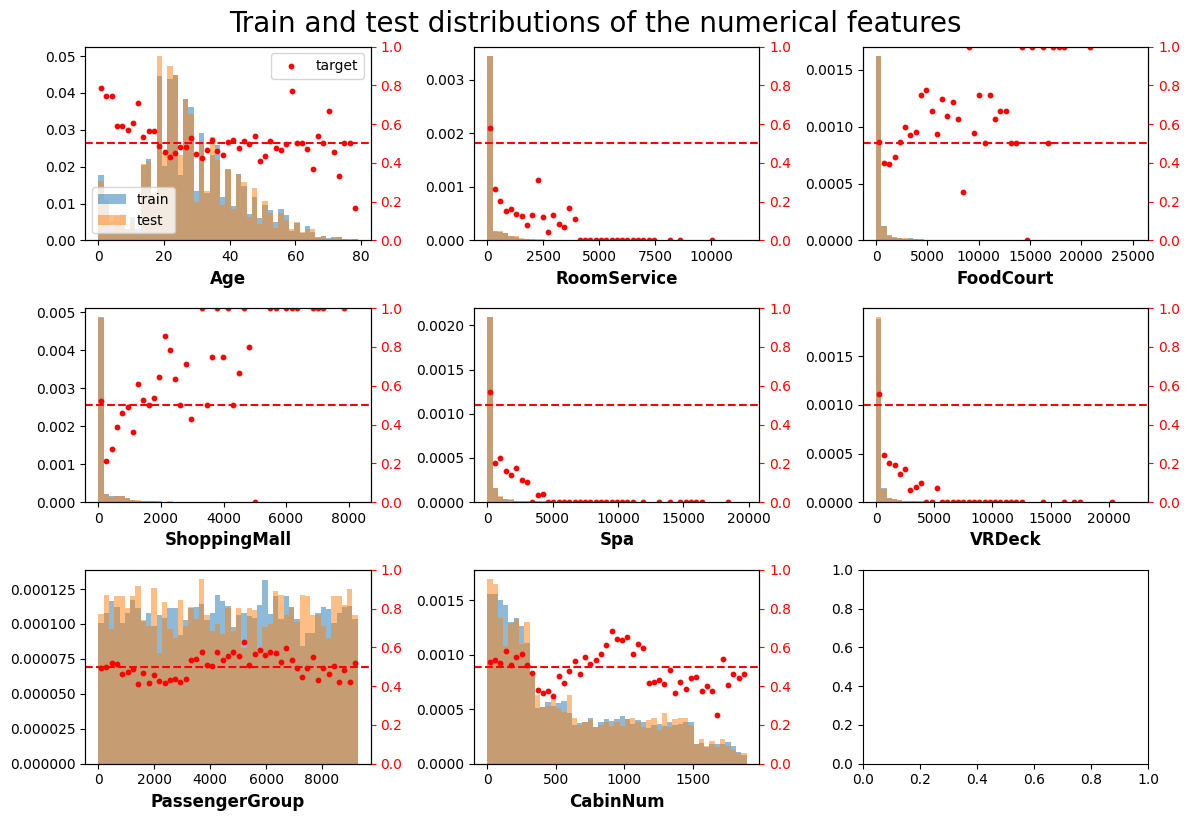

In [11]:
import warnings

def num_distr_plot(train, test, cols, target):
    rows = int(np.ceil(len(cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for f, ax in zip(cols, axes.ravel()):
        min_val = min(train[f].min(), test[f].min())
        max_val = min(train[f].max(), test[f].max())
        bins = np.linspace(min_val, max_val, 50)
        ax.hist(train[f], bins=bins, alpha=0.5, density='True', label='train')
        ax.hist(test[f], bins=bins, alpha=0.5, density='True', label='test')
        ax.set_xlabel(f)
        if ax == axes.flat[0] : ax.legend(loc = 'lower left')
        ax2 = ax.twinx()
        total, _ = np.histogram(train[f], bins=bins)
        target_count, _ = np.histogram(train[f][train[target] == 1], bins=bins)
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            ax2.scatter((bins[1:] + bins[:-1]) / 2, target_count / total, s = 10, color = 'r', label = 'target')
            ax2.set_ylim(0., 1.)
            ax2.axhline(y=0.5, color='r', linestyle='--')
            ax2.tick_params(axis = 'y', colors = 'r')
            if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the numerical features', fontsize=20, y=1.02)
    plt.show() 
    
num_distr_plot(X, X_test, hc_cols, 'Transported')

We observe:
<ul>
    <li>Train and test features have similar distributions.</li>
    <li>Most distributions are skewed.</li>
    <li>People of lower age have greater probability to be transported and can be transformed into a categorical feature.</li>
    <li>The CabinNum feature can be transformed into a categorical feature according to the target probability.</li>
 </ul>
 The same analysis can be done for the categorical features

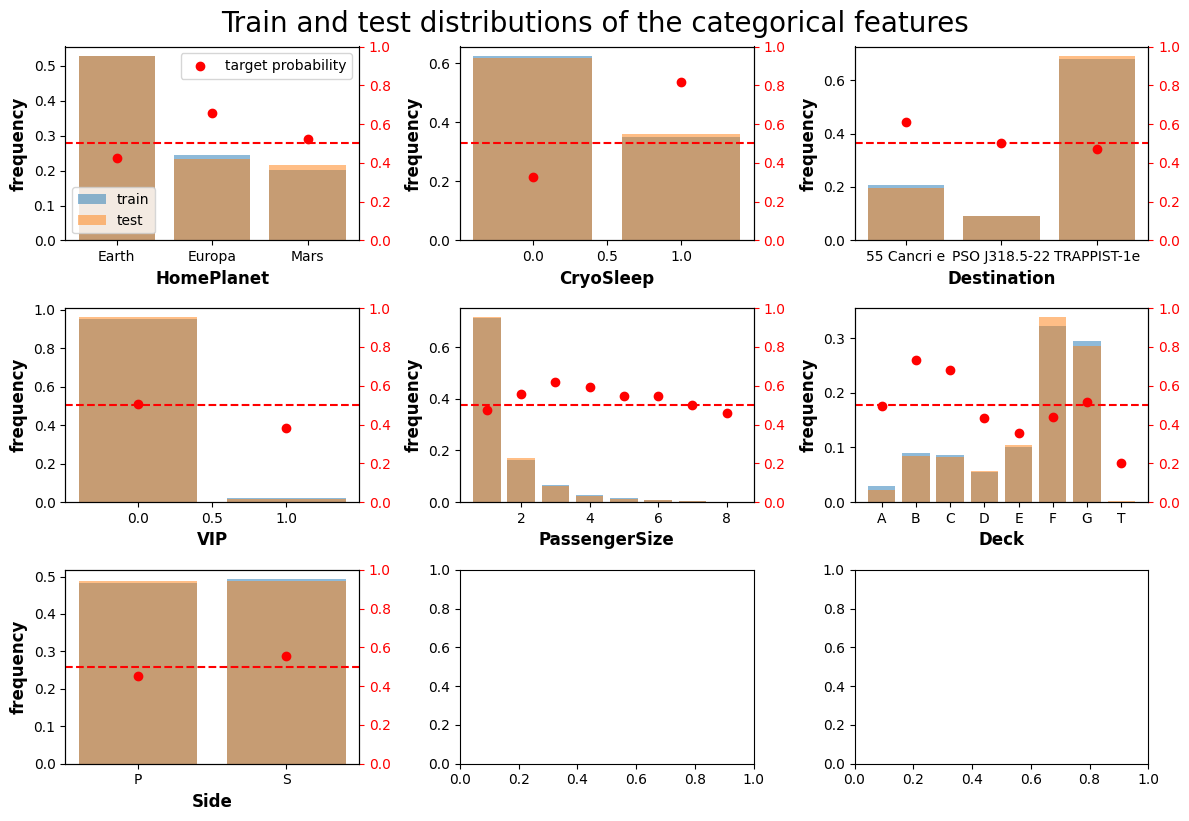

In [12]:
def cat_distr_plot(train, test, cols, target):
    rows = int(np.ceil(len(cols)/3))
    _, axes = plt.subplots(rows,3, figsize=(12,8))
    for f, ax in zip(cols, axes.ravel()):
        temp1 = train[target].groupby(train[f]).agg(['mean', 'size'])
        ax.bar(temp1.index, temp1['size'] / len(train), alpha=0.5, label='train')
        temp2 = test[f].value_counts()
        ax.bar(temp2.index, temp2 / len(test), alpha=0.5, label='test')
        ax.set_xlabel(f)
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax.set_ylabel('frequency')
        ax2 = ax.twinx()
        ax2.scatter(temp1.index, temp1['mean'], color='r', label='target probability')
        ax2.axhline(y=0.5, color='r', linestyle='--')
        ax2.set_ylim(0., 1.)
        ax2.tick_params(axis='y', colors='r')
        if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()
    del temp1, temp2 

cat_distr_plot(X, X_test, lc_cols, 'Transported')

As observed before CryoSleep is a promising feature to use in a model.

<h2>Feature Engineering</h2>

We produce the categorical data from Age and CabinNum.

In [13]:
X['AgeGroup'] = pd.cut(X['Age'], bins=[0, 12, 18, 25, 30, 50, np.inf], 
labels=[1, 2, 3, 4, 5, 6]).astype('Int64')
X['CabinSec'] = pd.cut(X['CabinNum'], bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf], 
    labels=[1, 2, 3, 4, 5, 6, 7]).astype('Int64')
X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=[0, 12, 18, 25, 30, 50, np.inf], 
labels=[1, 2, 3, 4, 5, 6]).astype('Int64')
X_test['CabinSec'] = pd.cut(X_test['CabinNum'], bins = [0, 300, 600, 900, 1200, 1500, 1800, np.inf], 
    labels=[1, 2, 3, 4, 5, 6,7]).astype('Int64')

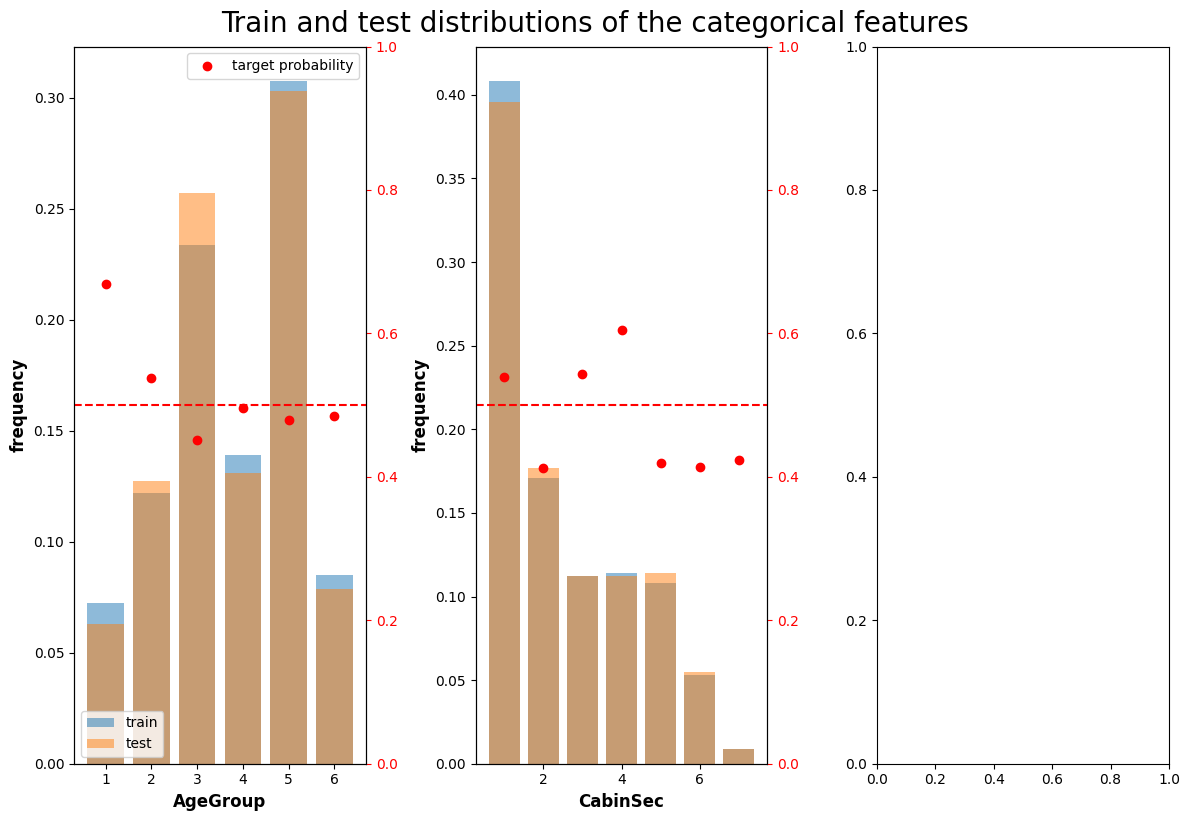

In [14]:
cat_distr_plot(X, X_test, ['AgeGroup', 'CabinSec'], 'Transported')

We select the categorical and numerical features for the model, setting a limited number and performing a log-transformation on the numerical features to correct skewed distribution:

In [15]:
cat_feats = ['CryoSleep', 'AgeGroup', 'CabinSec']
num_feats = ['RoomService', 'Spa', 'VRDeck']
for colname in num_feats:
    X[colname] = np.log(1 + X[colname])
    X_test[colname] = np.log(1 + X_test[colname])

<h2>Preprocessing and model setup</h2>

We select three model:
<ul>
    <li>Logistic Regression</li> 
    <li>Random Forest Classifier</li> 
    <li>Support Vector Machine</li> 
</ul>

In [16]:
my_feats = cat_feats + num_feats

X_train = X[my_feats]
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer  
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=10)),
    ('scaler', MinMaxScaler()),
])
prep_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_feats),
    ('num', num_pipeline, num_feats),
])

model_lr = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)

model_rfr = RandomForestClassifier(n_estimators = 50,  random_state=1)

model_svm = SVC(kernel='rbf', gamma='auto', C=1,  random_state=1)

pipeline_lr = Pipeline([
    ('preprocessor', prep_pipeline),
    ('model', model_lr),
])

pipeline_rfr = Pipeline([
    ('preprocessor', prep_pipeline),
    ('model', model_rfr),
])

pipeline_svm = Pipeline([
    ('preprocessor', prep_pipeline),
    ('model', model_svm),
])

<h2>Model Evaluation</h2>

To gain a greater insight we look not only for the model accuracy, but we also produce the precision, recall and f1 score.

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

def model_eval(full_pipeline, train_data, target, cv=5):
    y_preds = cross_val_predict(full_pipeline, train_data, target, cv=cv)
    precision = precision_score(target, y_preds)
    recall = recall_score(target, y_preds)
    f1 = f1_score(target, y_preds)
    scores = cross_val_score(full_pipeline, train_data, target, cv=cv, scoring='accuracy')
    mean_acc = scores.mean()
    return [precision, recall, f1, mean_acc]

In [18]:
results = []
model_dict = {'Logistic' : pipeline_lr, 'Random Forest' : pipeline_rfr, 'SVC' : pipeline_svm}

y = y.astype(int)

for model in model_dict.keys():
    print(model)
    results.append(model_eval(model_dict[model], X_train, y, cv=5))

results_df = pd.DataFrame(results, columns = ['precision', 'recall', 'f1', 'mean_acc'], index=model_dict.keys())
results_df

Logistic
Random Forest
SVC


,precision,recall,f1,mean_acc
Logistic,0.805888,0.600274,0.688048,0.725872
Random Forest,0.726225,0.791914,0.757649,0.744858
SVC,0.773401,0.726587,0.749264,0.755093


<h2>Further improvements</h2>
<ul>
    <li>A grid search would help setting the best hyperparameters for each model</li>
    <li>More refined imputing techniques can be performed, by looking at people's surname/distribution in the different decks to group common features.</li>
</ul>